In [47]:
# !pip install torchvista
# !pip install requirements.txt
# !pip install --upgrade datasets

import datasets
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import cv2
import numpy as np
from torchvision import transforms as tr
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import timm
# import torchvista
# from torchvista import trace_model
import sklearn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torchvision


ENSEMBLE_PATH="/kaggle/input/ensemble-fai/pytorch/default/1/ensemble.pth"
RESCNN_PATH="/kaggle/input/rescnn/pytorch/default/1/rescnn_state.pth"
CNN_PATH="/kaggle/input/cnn/pytorch/default/1/cnn.pth"
VIT_PATH="/kaggle/input/vit-best/pytorch/default/1/vit_best.pth"
 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

# Model Architecture

## CNN architecture

In [2]:
class Block(nn.Module):
  """
  Description: Residual Block architecture modified to be without skip connection

  Input: 
  in_channels: int
  Number of channels present in input
  out_channels: int
  Number of output channels
  stride: 1
  Step size a filter uses to move across an image
  
  Output: Object
  Initialized instance of Block
  
  """
  def __init__(self, in_channels, out_channels,  stride=1):
        super(Block, self).__init__()
        self.conv1=nn.Sequential(
        nn.Conv2d(in_channels= in_channels,
                  out_channels= out_channels,
                  kernel_size=3,
                  stride=stride,
                  padding=1  ),
            nn.BatchNorm2d(num_features= out_channels ),
            nn.ReLU()
        )

        self.conv2= nn.Sequential(
            nn.Conv2d(in_channels= out_channels,
                      out_channels= out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1  ),
            nn.BatchNorm2d(num_features=out_channels )
        )

        self.resize=nn.Sequential()

        if in_channels != out_channels and stride!=1:

          self.resizer= nn.Sequential(
              nn.Conv2d(in_channels= in_channels,
                                out_channels= out_channels,
                                kernel_size=1,
                                stride=stride,
                                padding=0
                ),
              nn.BatchNorm2d(num_features=out_channels )
          )

        # self.fc= nn.Linear(in_features=OUT_CHANNELS , out_features= NUM_CLASSES)

  def forward(self,x):
        x= self.conv1(x)
        x= self.conv2(x)
        if self.resize == True:
          add_ = F.relu(x)+self.resizer(x) #skip connections
        else:
          add_=F.relu(x)
        return add_


class CNN(nn.Module):
  """
  Description: CNN model

  Input:  
  num_classes: int
  Number of classes involved in classification task
  stride: Array
  Step size a filter uses for corresponding block to move across an image
  blocks: Array
  Input size of each block in CNN
  
  Output: Object
  Initialized instance of CNN with Residual blocks
  
  """
  def __init__(self,blocks, stride, num_classes=6):
    super(CNN, self).__init__()

    self.conv1= nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels=blocks[0], kernel_size=3, stride=2, padding=3),
        nn.BatchNorm2d(64)
    )
    num_blocks= len(blocks)
    self.blocks= nn.ModuleList([
         Block(in_channels= blocks[i], out_channels= blocks[i]*2, stride= stride[i]) for i in range(num_blocks)
    ])

    self.avgpool= nn.AdaptiveAvgPool2d((1,1))
    self.fc= nn.Linear(blocks[-1]*2, num_classes)

  def forward(self,x):
    x= self.conv1(x)
    for i, b in enumerate(self.blocks):
        x= self.blocks[i](x)
    x= self.avgpool(x)

    x= x.view(x.size(0),-1)
    return self.fc(x)




cnn=  CNN(blocks= [64,128,256,512], stride=[1,2,2,2], num_classes=6)

cnn.to(device)

cnn.load_state_dict(
    torch.load(CNN_PATH, weights_only=True, map_location= torch.device(device)))
cnn.eval() 

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blocks): ModuleList(
    (0): Block(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (resize): Sequential()
    )
    (1): Block(
      (conv1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2

## ResCNN architecture

In [3]:
class ResidualBlock(nn.Module):
  """
  Description: Residual Block with skip connection

  Input: 
  in_channels: int
  Number of channels present in input
  out_channels: int
  Number of output channels
  stride: 1
  Step size a filter uses to move across an image
  
  Output: Object
  Initialized instance of Residual block
  
  """
  def __init__(self, in_channels, out_channels,  stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1=nn.Sequential(
        nn.Conv2d(in_channels= in_channels,
                  out_channels= out_channels,
                  kernel_size=3,
                  stride=stride,
                  padding=1  ),
            nn.BatchNorm2d(num_features= out_channels ),
            nn.ReLU()
        )

        self.conv2= nn.Sequential(
            nn.Conv2d(in_channels= out_channels,
                      out_channels= out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1  ),
            nn.BatchNorm2d(num_features=out_channels )
        )

        self.resize=nn.Sequential()

        if in_channels != out_channels or stride!=1:

          self.resizer= nn.Sequential(
              nn.Conv2d(in_channels= in_channels,
                                out_channels= out_channels,
                                kernel_size=1,
                                stride=stride,
                                padding=0
                ),
              nn.BatchNorm2d(num_features=out_channels )
          )
    
  def forward(self, x): 
        identity = x 
 
        out = self.conv1(x)
        out = self.conv2(out)
 
        if self.resizer is not None:
            identity = self.resizer(identity)
         
        out += identity 
 
        out = F.relu(out)
        
        return out


class ResCNN(nn.Module):
  """
  Description: CNN with Residual blocks

  Input:  
  num_classes: int
  Number of classes involved in classification task
  stride: Array
  Step size a filter uses for corresponding block to move across an image
  
  Output: Object
  Initialized instance of CNN with Residual blocks
  
  """
  def __init__(self,blocks, stride, num_classes=6):
    super(ResCNN, self).__init__()

    self.conv1= nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels=blocks[0], kernel_size=3, stride=2, padding=3),
        nn.BatchNorm2d(64)
    )
    num_blocks= len(blocks)
    self.blocks= nn.ModuleList([
         ResidualBlock(in_channels= blocks[i], out_channels= blocks[i]*2, stride= stride[i]) for i in range(num_blocks)
    ])

    self.avgpool= nn.AdaptiveAvgPool2d((1,1))
    self.fc= nn.Linear(blocks[-1]*2, num_classes)

  def forward(self,x):
    x= self.conv1(x)
    for i, b in enumerate(self.blocks):
        x= self.blocks[i](x)
    x= self.avgpool(x)

    x= x.view(x.size(0),-1)
    return self.fc(x)

res_cnn=  ResCNN(blocks= [64,128,256,512], stride=[1,2,2,2], num_classes=6)

res_cnn.to(device)


res_cnn.load_state_dict(
    torch.load(RESCNN_PATH, weights_only=True, map_location= torch.device(device)))
res_cnn.eval()

 

ResCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blocks): ModuleList(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (resize): Sequential()
      (resizer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(128, 256, kern

## Ensemble architecture

In [ ]:
class Ensemble(nn.Module):
  """
  Description: Stack ensemble model with first layer consisting of CNN and VIT and meta layer consisting of Logistic Regression Model

  Input: 
  num_classes: int
  Number of classes present in classification task

  Output: Object
  Initialized instance of Ensemble class
  
  """

  def __init__(self,num_classes=6):
    super(Ensemble, self).__init__()

    self.model1= CNN(blocks= [64,128,256,512], stride=[1,2,2,2], num_classes=num_classes)
    self.model1.to(device)
      
    self.model2= timm.create_model(
        "vit_tiny_patch16_224",   # tiny as base
        pretrained=True,
        img_size=(78,78),
        patch_size=6,
        in_chans=1,               # 1 channel (grayscale)
        num_classes=num_classes
    )
    self.model2.to(device)
      
    self.meta_layer= nn.Linear(num_classes*2,num_classes) 
    
    
  def forward(self,x):
      output1= self.model1(x)
      output2= self.model2(x)

      combined_input= torch.cat((output1,output2), dim=1)
      return self.meta_layer(combined_input)


ensemble = Ensemble()
ensemble.to(device)
ensemble.load_state_dict(
    torch.load(ENSEMBLE_PATH, weights_only=True, map_location= torch.device(device)))
ensemble.eval() 

## VIT Pretrained

In [48]:

vit = timm.create_model(
    "vit_tiny_patch16_224",   # tiny as base
    pretrained=True,
    img_size=(78,78),
    patch_size=6,
    in_chans=1,               # 1 channel (grayscale)
    num_classes=6
)

vit.to(device)
vit.load_state_dict(
    torch.load(VIT_PATH, weights_only=True, map_location= torch.device(device)))
vit.eval() 

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 192, kernel_size=(6, 6), stride=(6, 6))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
    

# Load data

In [6]:
ds = load_dataset("Genius-Society/HEp2", split="train")
train_split= ds.train_test_split(test_size=0.3, seed=42)  

test_set= train_split['test'].train_test_split(test_size=0.5, seed=42) 
 
test_set= test_set['train']

# store label names for classification report
label_names=ds.features["label"].names

README.md: 0.00B [00:00, ?B/s]

data.zip:   0%|          | 0.00/54.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13596 [00:00<?, ? examples/s]

# Testing functions

In [57]:
def check_by_label(pred,real, index=[0]):
    """
        Description: 
        Display label names of pred and real label_ids
        -----------------------------------------------------------------------------------
        Input:
        pred: Array
        Predicted labels of test data
        real: Array
        Actual labels of test data
        -----------------------------------------------------------------------------------
        Output: None 
        
    """
    pred_label_names= [label_names[p] for p in pred]
    test_label_names= [label_names[p] for p in real]
    for i in index:
        print(f"Pattern '{test_label_names[i]}' got classified as Pattern '{pred_label_names[i]}'")


def classification_matrix(pred,real, label_names= label_names):
    """
        Description: 
        Display classification matrix
        -----------------------------------------------------------------------------------
        Input:
        pred: Array
        Predicted labels of test data
        real: Array
        Actual labels of test data
        -----------------------------------------------------------------------------------
        Output: None 
        
    """
    
    print(classification_report(real, pred, digits=2,labels= [0,1,2,3,4,5], target_names = label_names,zero_division=1.0))


def test_dataset(model,test_data):
    """
        Description: 
        Performing testing on model using inputted dataset
        -----------------------------------------------------------------------------------
        Input:
        model: Object
        model used for prediction
        test_data: DataLoader
        Test data
        -----------------------------------------------------------------------------------
        Output: 
        test_preds: Array
        Predicted labels for test images
        test_labels: Array
        Actual labels of test images
        
    """
    test_pred= []
    test_labels= []
    
    with torch.no_grad():
        for i, batch in enumerate(test_data):
            image = batch['image'].to(device, non_blocking=True)
            labels= batch['label']
            outputs= model(image)
            _, preds= torch.max(outputs, dim=1)
    
            test_pred.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
        test_preds= np.array(test_pred)
        test_labels= np.array(test_labels)
    
    return test_preds, test_labels



# Preprocessing

In [18]:
class Normalize:
    """
    Description: Preprocessing function to perform image enhancement via image stretching using 
    the 1st and 99th quantile intensities and normalization.
    """
    def __init__(self):
        pass

    def __call__(self,img):  
        """
        Input: torch.Tensor
        Image to be normalized
        
        Output: torch.Tensor
        Normalized image
        """
        img_flatten = img.flatten()
        q1= torch.quantile(img_flatten, 0.01)
        q99 = torch.quantile(img_flatten, 0.99)

        if q1== q99:
            return torch.clamp(img, 0,1)

        stretch_img = torch.clamp(img, q1,q99) 
        normalized = ((stretch_img - q1) / (q99  - q1)) #*(255-0) + 0

        return torch.clamp(normalized, min= 0, max= 1.0) 



def apply_preproc(data ):
    """
        Description:
        Initialize Transform function to apply basic preprocessing by conversion of data to tensor
        and performing image normalization
        -----------------------------------------------------------------------------------
        Input:
            data: 
            Input a row from the dataset consisting of images and corresponding labels 
        -----------------------------------------------------------------------------------
        Output: dict
        Return transformed row
        
    """
    transform= tr.Compose([ 
                              tr.ToTensor(), 
                              Normalize(), 
                        ])
    return {'image': transform(data['image']), 'label': data['label']}  

def view_image(image):
    view_img= tr.Compose([ 
        tr.ToTensor(),
                    tr.RandomRotation(degrees=(18)) , 
                    tr.ColorJitter(brightness=np.random.uniform(0.1,0.15)),
                    # tr.ElasticTransform(alpha=np.random.uniform(49.7, 50), sigma=5.0),
                           tr.ToPILImage()
                ]) 
    return view_img(image)

# Initialize dataset

In [9]:

class Hep2Dataset:
    """
    Custom dataset to prepare images to be loaded into the dataloader.
    """
    def __init__(self, data, set_type="", rotation=18):
        """
        Description:
        Initialize Dataset as an object
        -----------------------------------------------------------------------------------
        Input:
            data: 
            Input dataset
            
            set_type: str, "" default
            Determine input dataset is for training purpose.
            If set_type = "augment", dataset is meant for data augmentation.
            
            rotation: int, 18 default
            Degree of rotation for image augmentation.
        -----------------------------------------------------------------------------------
        Output: None
        
        """
        super().__init__() 

        self.ds= data
        self.set_type= set_type

        self.labels= data.to_pandas()['label'] #labels of each image in the dataset
        
        
        self.transform=None
        if set_type== "augment":
            # Initialize transform for dataaugmentation using random rotation and brightness adjustment
            self.transform=tr.Compose([ 
                    tr.RandomRotation(degrees=(rotation)) ,
                    tr.ColorJitter(brightness=0.1)
                ]) 

    def get_weights(self):
        """
        Description: 
        Generate weights for the dataset for random sampling
        -----------------------------------------------------------------------------------
        Input: None
        -----------------------------------------------------------------------------------
        Output:
        sample_weights: array
        List of weights for each label
        """
        label_counts= self.labels.value_counts() 
        sample_weights= self.labels.map(1/label_counts).tolist()
        return sample_weights
        
    def __len__(self):
        """
        Description: 
        Returns length of dataset
        -----------------------------------------------------------------------------------
        Input:None
        -----------------------------------------------------------------------------------
        Output: int
        length of dataset 
        """
        return len(self.ds)

    def __getitem__(self, idx):
        """
        Description: 
        Returns image and corresponding label at a particular index
        -----------------------------------------------------------------------------------
        Input:
        idx: int
        Index to retrieve image and label from
        -----------------------------------------------------------------------------------
        Output: dict
        Dictionary with image and label at a particular index
        
        """
        if self.set_type == "augment":
            image= self.transform(self.ds[idx]['image'])
        else:
            image= self.ds[idx]['image']
        
        label = self.ds[idx]['label']
        
        return {'image': image, 'label' : label}


 

In [10]:
num_proc= 4 
samples= 5 #number of samples to be included from each label type
def load_subsets(data= test_set, num_proc=num_proc):
    """
        Description: 
        Create sub-datasets which consist of only one particular label with index corresponding to label_id
        -----------------------------------------------------------------------------------
        Input:
        data: datasets.arrow_dataset.Dataset
        Data to be divided into sub-datasets based on their label ids
        -----------------------------------------------------------------------------------
        Output: Array
        Array of datasets containing data corresponding to one particular label id
        
    """
    
    label_samples=[]
    for i in range(6):
        print(f"filtering for label {i}...")
        label_samples.append( 
            data.filter(lambda x:  x['label'] == i,num_proc=num_proc).shuffle()
        )
    return label_samples


label_samples= load_subsets()



filtering for label 0...


Filter (num_proc=4):   0%|          | 0/2039 [00:00<?, ? examples/s]

filtering for label 1...


Filter (num_proc=4):   0%|          | 0/2039 [00:00<?, ? examples/s]

filtering for label 2...


Filter (num_proc=4):   0%|          | 0/2039 [00:00<?, ? examples/s]

filtering for label 3...


Filter (num_proc=4):   0%|          | 0/2039 [00:00<?, ? examples/s]

filtering for label 4...


Filter (num_proc=4):   0%|          | 0/2039 [00:00<?, ? examples/s]

filtering for label 5...


Filter (num_proc=4):   0%|          | 0/2039 [00:00<?, ? examples/s]

In [59]:

BATCH_SIZE=64
NUM_WORKERS=4
  
def defined_inputs(data):
        """
        Description: 
        Preprocess the dataset and load it into data loader
        -----------------------------------------------------------------------------------
        Input:
        data: datasets.arrow_dataset.Dataset or dict
        Dataset to be preprocessed
        -----------------------------------------------------------------------------------
        Output: datasets.Dataset
        Dataloader of inputted dataset
        
        """
        if isinstance(data, dict): 
                print("converting to hugging face format")
                data= Dataset.from_dict(data)
            
        # if isinstance(data, datasets.arrow_dataset.Dataset):
        print("Applying initial preprocessing..")
        data = data.map(
                apply_preproc,  
                batched=False
            )
        data= data.with_format('torch') 

        print("loading data", type(data)) 
        dataset= Hep2Dataset(data)
        
        data_loader= DataLoader(dataset,
                                batch_size= BATCH_SIZE,
                                prefetch_factor=2,
                                num_workers=NUM_WORKERS,
                                pin_memory=True,
                                persistent_workers=True ,
                                shuffle=True)
        return data_loader
            



# Test on data

In [31]:
def classify(model=cnn, test_data=test_data):
    """
        Description: 
        Test on inputted models using inputed test data and display classification matrix
        -----------------------------------------------------------------------------------
        Input:
        models: Array
        Array of models to train upon
        
        test_data: DataLoader
        Data to be tested upon
        -----------------------------------------------------------------------------------
        Output: dict
        Dictionary containing actual and predicted labels for each model
        
        """ 
    
    print(f"Testing on model {model.__class__.__name__}..")
        
    preds, labels= test_dataset(model,test_data) 
     
    return {"preds": preds, "real": labels}


# classify()

## Pre-defined inputs

In [68]:

def predefine_data(label_samples=label_samples, samples=5):
    # Create pre-defined dataset using given number of samples
    """
        Description: 
        Create pre-defined dataset using given number of samples from each label
        -----------------------------------------------------------------------------------
        Input:
        data: Array
        Array of datasets from which data is to be sampled from
        -----------------------------------------------------------------------------------
        Output: datasets.arrow_dataset.Dataset
        Combined dataset containing 5 samples of each label
        
    """
    print(f"Fetching {samples} samples from each class")
    sample_data= [ Dataset.from_dict(label_samples[i][:samples]) for i in range(6)]
    predefined_samples= datasets.concatenate_datasets(sample_data)
    print(f"Created dataset of {len(predefined_samples)} samples")
    return predefined_samples

predefined_test = predefine_data()

predef_data=defined_inputs(predefined_test) 
models= [vit,cnn,res_cnn, ensemble]

for model in models:
    outputs= classify(model=model, test_data=predef_data) 
    classification_matrix(outputs["preds"], outputs["real"]) 
    break 

Fetching 5 samples from each class
Created dataset of 30 samples
Applying initial preprocessing..


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

loading data <class 'datasets.arrow_dataset.Dataset'>
Testing on model VisionTransformer..
              precision    recall  f1-score   support

  Centromere       0.83      1.00      0.91         5
       Golgi       1.00      0.60      0.75         5
 Homogeneous       1.00      1.00      1.00         5
       NuMem       1.00      1.00      1.00         5
   Nucleolar       0.83      1.00      0.91         5
    Speckled       0.80      0.80      0.80         5

    accuracy                           0.90        30
   macro avg       0.91      0.90      0.89        30
weighted avg       0.91      0.90      0.89        30



## User defined inputs

converting to hugging face format
Applying initial preprocessing..


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

loading data <class 'datasets.arrow_dataset.Dataset'>


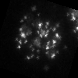

In [65]:
# Taking 2 samples
chosen_sample = label_samples[0][0] 
chosen_sample2 = label_samples[4][0]
 
user_defined = {
    "image": [chosen_sample['image'],chosen_sample2['image']],
    "label": [chosen_sample['label'],chosen_sample2['label']]
}
test_data= defined_inputs(user_defined)

# Preview an image
view_image(chosen_sample['image']) 


In [66]:

output= classify(model=vit,test_data=test_data)
print(output)
# To view label names of classification output
check_by_label(output["preds"], output["real"], index= [0,1])

# To build classification matrix only when there is data for all 6 labels present
classification_matrix(output["preds"], output["real"])

Testing on model VisionTransformer..
{'preds': array([4, 0]), 'real': array([4, 0])}
Pattern 'Nucleolar' got classified as Pattern 'Nucleolar'
Pattern 'Centromere' got classified as Pattern 'Centromere'
              precision    recall  f1-score   support

  Centromere       1.00      1.00      1.00         1
       Golgi       1.00      1.00      1.00         0
 Homogeneous       1.00      1.00      1.00         0
       NuMem       1.00      1.00      1.00         0
   Nucleolar       1.00      1.00      1.00         1
    Speckled       1.00      1.00      1.00         0

   micro avg       1.00      1.00      1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

